##Name: Ebrahim Hirani
##UID: 2018130015
##Batch: A
##Objective
###Data Classification

Objective:

(i) Apply Naive bayes classifier for given data see Naive_bayes_handout.zip file in edmodo.

(ii) Apply and compare Linear Discriminating Analysis with Naive bayes classifiers w.r.t. error, specificity and sensitivity

Loading and preprocessing Dataset


In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os


Mounted at /content/drive/


In [14]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df_train = pd.read_csv('/content/drive/MyDrive/DS_3/Constraint_Train.csv', index_col ='id')
df_train.head()

,tweet,label
id,,
1,The CDC currently reports 99031 deaths. In gen...,real
2,States reported 1121 deaths a small rise from ...,real
3,Politically Correct Woman (Almost) Uses Pandem...,fake
4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
5,Populous states can generate large case counts...,real


In [3]:
df_test = pd.read_csv('/content/drive/MyDrive/DS_3/Constraint_Val.csv', index_col ='id')
df_test.head()

,tweet,label
id,,
1,Chinese converting to Islam after realising th...,fake
2,11 out of 13 people (from the Diamond Princess...,fake
3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
4,Mike Pence in RNC speech praises Donald Trump’...,fake
5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [4]:
def change(s):
  if s == 'real':
    return 1
  else:
    return 0

df_train['label'] = df_train['label'].apply(lambda x : change(x))

In [5]:
def change_t(s):
  if s == 'real':
    return 1
  else:
    return 0

df_test['label'] = df_test['label'].apply(lambda x : change_t(x))

In [6]:
!pip install nltk

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Text(0.5, 1.0, 'Data Distribution')

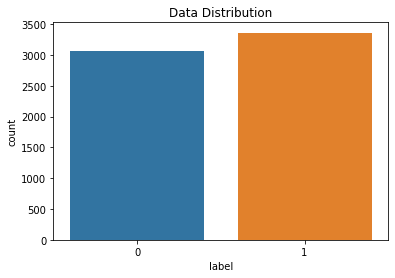

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(x = "label", data = df_train)
plt.title("Data Distribution")

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Data distribution seems quite workable.

Removing punctuation and unnecessary stop words.
Using stemmer to get similar results for different forms of the same words

In [10]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 

stop_words =set(stopwords.words("english"))
stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')
from nltk.stem import PorterStemmer 

def preprocess(text):
  word_list = []
  tok = tokenizer.tokenize(text)
  for word in tok:
    if word not in stop_words:
      word_list.append(stemmer.stem(word))
  return " ".join(word_list)

In [11]:
x_data = df_train["tweet"].apply(preprocess)
x_data.tail()

id
6416    A tiger test posit covid 19 pleas stay away pe...
6417    autopsi prove covid 19 blood clot pneumonia ou...
6418    _A post claim covid 19 vaccin alreadi develop ...
6419       aamir khan donat 250 Cr In PM relief care fund
6420    It 93 day sinc last case covid 19 acquir local...
Name: tweet, dtype: object

http 4398
covid 2158
case 2054
19 1809
test 1695
coronaviru 1661
covid19 1493
new 1198
state 1047
report 1041
death 839
peopl 755
number 701
day 592
hospit 576
total 558
confirm 541
india 519
amp 480
health 425


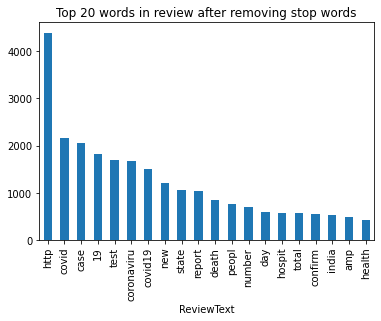

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(x_data, 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in review after removing stop words')


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_data, df_train['label'].values, test_size=0.10, random_state=42)

Using tf-idf to further minimize the weight of unnecessary words.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(X_train)
x_test_tfidf = vectorizer.transform(X_test)

Important features:

In [23]:
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
# sort ascending
df_idf.sort_values(by=['idf_weights'], ascending=False).head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,idf_weights
𝗶𝗻𝗮𝗰𝘁𝗶𝘃𝗮𝘁𝗲,8.968839
lachupacabra,8.968839
lafyuehdla,8.968839
lagard,8.968839
lager,8.968839


Since tf-idf gives more weightage to rare words, it is evident by the list of words with high weight.

In [40]:
len(df_idf)

14030

In [22]:
from sklearn.naive_bayes import BernoulliNB


In [24]:
BernModel = BernoulliNB()
BernModel.fit(x_train_tfidf, y_train)
print(f"Training Score : {BernModel.score(x_train_tfidf, y_train)}")
print(f"Test Score : {BernModel.score(x_test_tfidf, y_test)}")

Training Score : 0.9518864659051575
Test Score : 0.9049844236760125


Mean Absolute Error: 0.09501557632398754
Accuracy: 0.9049844236760125
              precision    recall  f1-score   support

           0      0.862     0.950     0.904       302
           1      0.951     0.865     0.906       340

    accuracy                          0.905       642
   macro avg      0.907     0.908     0.905       642
weighted avg      0.909     0.905     0.905       642



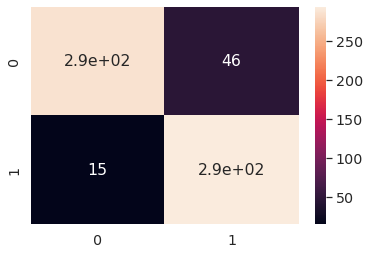

In [31]:
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns

test_pred = BernModel.predict(x_test_tfidf)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_pred))
print('Accuracy: %s' % metrics.accuracy_score(y_test, test_pred))
print(metrics.classification_report(y_test, test_pred, digits=3))
cm = metrics.confusion_matrix(test_pred, y_test)
sns.set(font_scale=1.3)
sns.heatmap(cm, annot=True)
plt.show() 

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components = 1)

In [33]:
lda.fit(x_train_tfidf.todense(), y_train)
print(f"Training Score : {lda.score(x_train_tfidf.todense(), y_train)}")
print(f"Test Score : {lda.score(x_test_tfidf.todense(), y_test)}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



Training Score : 1.0
Test Score : 0.6448598130841121


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



Mean Absolute Error: 0.35514018691588783
Accuracy: 0.6448598130841121
              precision    recall  f1-score   support

           0      0.626     0.609     0.617       302
           1      0.661     0.676     0.669       340

    accuracy                          0.645       642
   macro avg      0.643     0.643     0.643       642
weighted avg      0.644     0.645     0.645       642



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



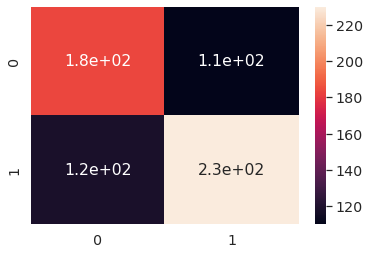

In [34]:
test_pred = lda.predict(x_test_tfidf.todense())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_pred))
print('Accuracy: %s' % metrics.accuracy_score(y_test, test_pred))
print(metrics.classification_report(y_test, test_pred, digits=3))
cm = metrics.confusion_matrix(test_pred, y_test)
sns.set(font_scale=1.3)
sns.heatmap(cm, annot=True)
plt.show()

##We reduce the number of features and train both models again.

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 2000)
x_train_tfidf = vectorizer.fit_transform(X_train)
x_test_tfidf = vectorizer.transform(X_test)

In [43]:
df_idf = pd.DataFrame(vectorizer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
# sort ascending
df_idf.sort_values(by=['idf_weights'], ascending=False).head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,idf_weights
bidensoetoro,8.052548
vermont,8.052548
rash,8.052548
oil,7.870226
sepsi,7.870226


In [38]:
BernModel = BernoulliNB()
BernModel.fit(x_train_tfidf, y_train)
print(f"Training Score : {BernModel.score(x_train_tfidf, y_train)}")
print(f"Test Score : {BernModel.score(x_test_tfidf, y_test)}")

Training Score : 0.9203876773970232
Test Score : 0.8987538940809969


Mean Absolute Error: 0.10124610591900311
Accuracy: 0.8987538940809969
              precision    recall  f1-score   support

           0      0.852     0.950     0.898       302
           1      0.951     0.853     0.899       340

    accuracy                          0.899       642
   macro avg      0.901     0.902     0.899       642
weighted avg      0.904     0.899     0.899       642



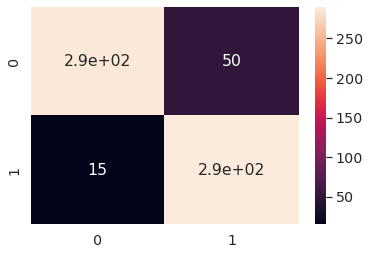

In [39]:
from sklearn import metrics
from sklearn import preprocessing
import seaborn as sns

test_pred = BernModel.predict(x_test_tfidf)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_pred))
print('Accuracy: %s' % metrics.accuracy_score(y_test, test_pred))
print(metrics.classification_report(y_test, test_pred, digits=3))
cm = metrics.confusion_matrix(test_pred, y_test)
sns.set(font_scale=1.3)
sns.heatmap(cm, annot=True)
plt.show() 

In [41]:
lda = LinearDiscriminantAnalysis()
lda.fit(x_train_tfidf.todense(), y_train)
print(f"Training Score : {lda.score(x_train_tfidf.todense(), y_train)}")
print(f"Test Score : {lda.score(x_test_tfidf.todense(), y_test)}")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



Training Score : 0.9837313949463482
Test Score : 0.9174454828660437


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



Mean Absolute Error: 0.08255451713395638
Accuracy: 0.9174454828660437
              precision    recall  f1-score   support

           0      0.900     0.927     0.914       302
           1      0.934     0.909     0.921       340

    accuracy                          0.917       642
   macro avg      0.917     0.918     0.917       642
weighted avg      0.918     0.917     0.917       642



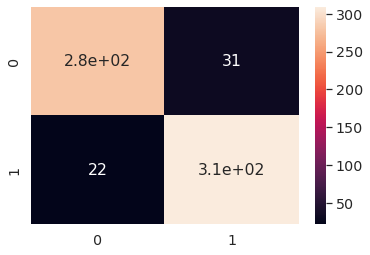

In [42]:
test_pred = lda.predict(x_test_tfidf.todense())
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, test_pred))
print('Accuracy: %s' % metrics.accuracy_score(y_test, test_pred))
print(metrics.classification_report(y_test, test_pred, digits=3))
cm = metrics.confusion_matrix(test_pred, y_test)
sns.set(font_scale=1.3)
sns.heatmap(cm, annot=True)
plt.show()

##Conclusion:

*  The Naive Bayes Model works similarly for the whole set of features as well as reduced set of features.

*  The LDA model performs poorly for the whole set of features, but performs better and even exceeds the performance of the Naive Bayes model after the reduced set of features.

*  The training times are reduced significantly after reducing the features without any loss in model performance loss and in the case of LDA, it causes significant improvement

*  This highlights the expendability of the less important features and efficiency of TF-IDF